**Plan of Action**

1. Load **IMDb Movie Reviews** dataset (50,000 reviews)

2. **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert** sentiment labels** positive & negative to numbers 1 & 0, respectively

3. **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus

4. **Model Training using Deep Learning** in Keras for separate:** Simple Neural Net, CNN and LSTM Models** and analyse model performance and results.

5. Last, perform **predictions on real IMDb movie reviews**





***import libraries***

In [14]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, GlobalMaxPooling1D, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


***Loading dataset***

In [15]:
from google.colab import files
uploaded = files.upload()

Saving IMDB_Dataset.csv to IMDB_Dataset.csv


In [16]:
# Load dataset
movie_reviews = pd.read_csv("IMDB_Dataset.csv")

In [17]:
# Check shapes
movie_reviews.shape

(50000, 2)

In [18]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [19]:
# Checking for missing values
movie_reviews.isnull().values.any()

False

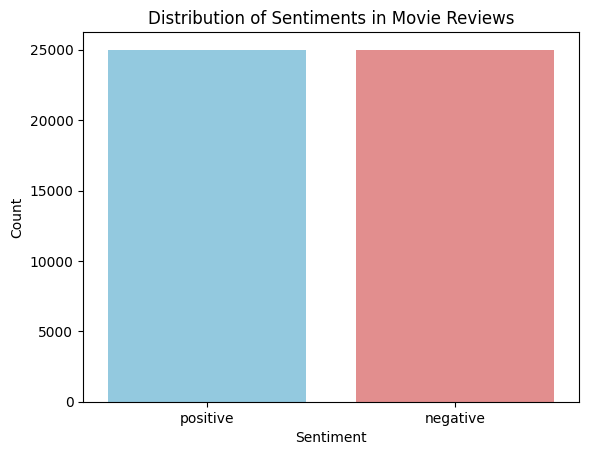

In [20]:
# Let's observe distribution of positive / negative sentiments in dataset
colors = ["skyblue", "lightcoral"]
sns.countplot(x='sentiment', hue='sentiment', data=movie_reviews, palette=colors, legend=False)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Movie Reviews')

plt.show()

**Data Preprocessing**

In [21]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

***You can see that our text contains punctuations, brackets, HTML tags and numbers***

***We will preprocess this text in the next section***

In [22]:
# Removing tags
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text) #Removes HTML tags: replaces anything between opening and closing <> with empty space

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [25]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [26]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [27]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

**Train-test split**

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Preparing embedding layer**

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras.**

In [29]:
# Tokenize and pad sequences
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [35]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(tokenizer.word_index) + 1
vocab_length

92394

In [36]:
# Padding all reviews to fixed length 100
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [37]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [38]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus


embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [39]:
embedding_matrix.shape

(92394, 100)

**Model Architectures**

***Simple Neural Network (SNN)***

In [40]:
from tensorflow.keras.regularizers import l2



In [61]:
# Define model architecture
snn_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
snn_model.add(embedding_layer)

# Flatten layer
snn_model.add(Flatten())

# Dense layers with regularization and dropout
snn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
snn_model.add(Dropout(0.5))  # Dropout layer to reduce overfitting
snn_model.add(Dense(1, activation='sigmoid'))

In [62]:
# Model compiling
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Print model summary
print(snn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                640064    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9879529 (37.69 MB)
Trainable params: 640129 (2.44 MB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [63]:
# Model training with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                                  validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 2s 4ms/step - loss: 0.6987 - acc: 0.6739 - val_loss: 0.6031 - val_acc: 0.7415
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.5863 - acc: 0.7557 - val_loss: 0.5756 - val_acc: 0.7639
Epoch 3/20
250/250 [==============================] - 1s 6ms/step - loss: 0.5504 - acc: 0.7782 - val_loss: 0.5776 - val_acc: 0.7676
Epoch 4/20
250/250 [==============================] - 3s 11ms/step - loss: 0.5321 - acc: 0.7923 - val_loss: 0.5892 - val_acc: 0.7596
Epoch 5/20
250/250 [==============================] - 2s 8ms/step - loss: 0.5275 - acc: 0.7947 - val_loss: 0.6002 - val_acc: 0.7625


In [64]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)


313/313 [==============================] - 1s 3ms/step - loss: 0.5868 - acc: 0.7546


In [65]:
# Evaluate model on test set
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5867990255355835
Test Accuracy: 0.7545999884605408


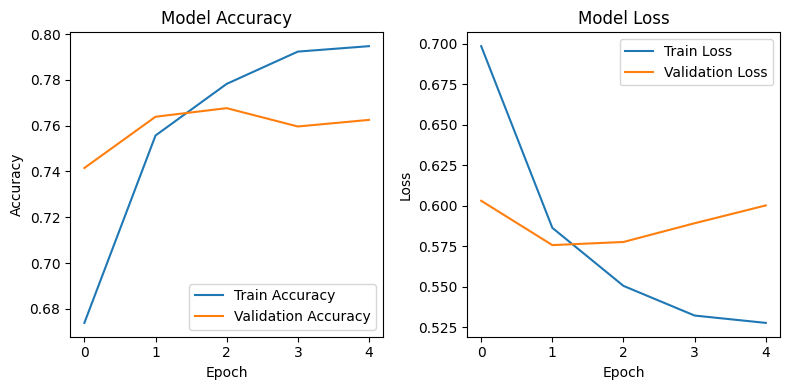

In [66]:
# Plotting model performance
plt.figure(figsize=(8, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(snn_model_history.history['acc'], label='Train Accuracy')
plt.plot(snn_model_history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(snn_model_history.history['loss'], label='Train Loss')
plt.plot(snn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Convolutional Neural Network**

In [67]:
# Define CNN model architecture
cnn_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

# Convolutional layers with regularization and dropout
cnn_model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

# Dense output layer
cnn_model.add(Dense(1, activation='sigmoid'))

In [68]:
# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Print model summary
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
__________

In [69]:
# Model training with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                                  validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
250/250 [==============================] - 4s 7ms/step - loss: 0.6544 - acc: 0.7113 - val_loss: 0.5164 - val_acc: 0.8125
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 0.5011 - acc: 0.8058 - val_loss: 0.4633 - val_acc: 0.8300
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4626 - acc: 0.8246 - val_loss: 0.4439 - val_acc: 0.8357
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4424 - acc: 0.8303 - val_loss: 0.4358 - val_acc: 0.8389
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4280 - acc: 0.8414 - val_loss: 0.4301 - val_acc: 0.8424
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4179 - acc: 0.8459 - val_loss: 0.4270 - val_acc: 0.8424
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4064 - acc: 0.8539 - val_loss: 0.4242 - val_acc: 0.8440
Epoch 8/20
250/250 [==============================] - 1s 4ms/step - loss: 0.

In [70]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.4196 - acc: 0.8455


In [72]:
# Evaluate model on test set
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4195610284805298
Test Accuracy: 0.8454999923706055


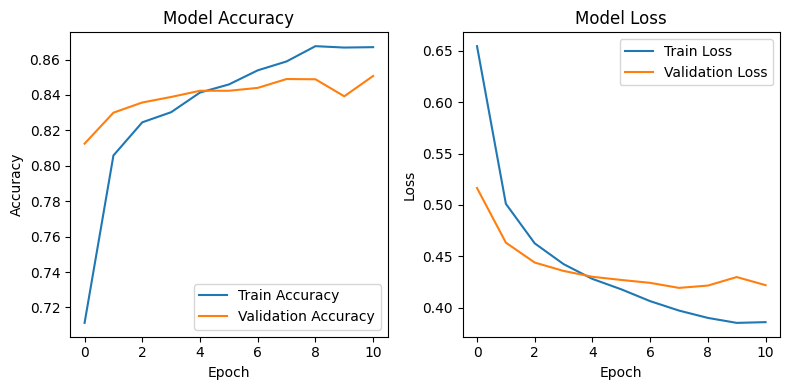

In [73]:
# Plotting model performance
plt.figure(figsize=(8, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_model_history.history['acc'], label='Train Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(cnn_model_history.history['loss'], label='Train Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Recurrent Neural Network (LSTM)**

In [41]:
# Define LSTM model architecture with an additional Dense layer
lstm_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)

# LSTM layer with dropout
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))  # return_sequences=False for final LSTM layer

# Additional Dense layer
lstm_model.add(Dense(64, activation='relu'))

# Dropout for regularization
lstm_model.add(Dropout(0.2))

# Final Dense output layer for binary classification
lstm_model.add(Dense(1, activation='sigmoid'))

In [42]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Print model summary
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9364969 (35.72 MB)
Trainable params: 125569 (490.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [43]:
# Model training with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 48s 173ms/step - loss: 0.5450 - acc: 0.7276 - val_loss: 0.4787 - val_acc: 0.7986
Epoch 2/20
250/250 [==============================] - 45s 181ms/step - loss: 0.4527 - acc: 0.7904 - val_loss: 0.4214 - val_acc: 0.8010
Epoch 3/20
250/250 [==============================] - 40s 161ms/step - loss: 0.4030 - acc: 0.8200 - val_loss: 0.3594 - val_acc: 0.8479
Epoch 4/20
250/250 [==============================] - 41s 162ms/step - loss: 0.3770 - acc: 0.8347 - val_loss: 0.3431 - val_acc: 0.8530
Epoch 5/20
250/250 [==============================] - 44s 177ms/step - loss: 0.3546 - acc: 0.8465 - val_loss: 0.3304 - val_acc: 0.8566
Epoch 6/20
250/250 [==============================] - 40s 161ms/step - loss: 0.3424 - acc: 0.8527 - val_loss: 0.3333 - val_acc: 0.8584
Epoch 7/20
250/250 [==============================] - 40s 161ms/step - loss: 0.3270 - acc: 0.8615 - val_loss: 0.3440 - val_acc: 0.8631
Epoch 8/20
250/250 [==============================] - 4

In [44]:
# Evaluate model on test set
score = lstm_model.evaluate(X_test, y_test, verbose=1)


313/313 [==============================] - 11s 34ms/step - loss: 0.3073 - acc: 0.8731


In [45]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3073427677154541
Test Accuracy: 0.8730999827384949


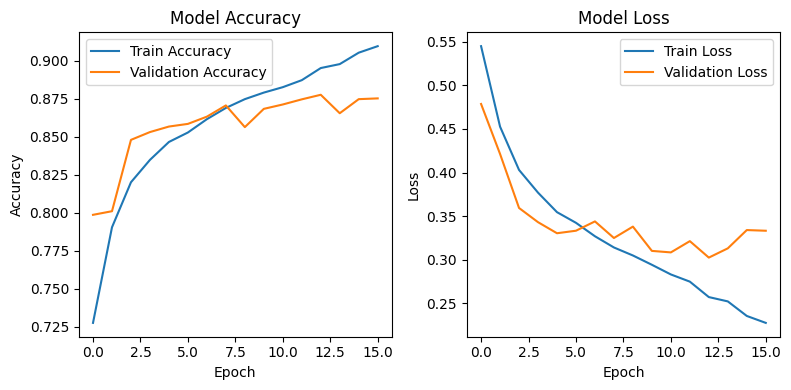

In [46]:
# Plotting model performance
plt.figure(figsize=(8, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_model_history.history['acc'], label='Train Accuracy')
plt.plot(lstm_model_history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(lstm_model_history.history['loss'], label='Train Loss')
plt.plot(lstm_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Save the best model and tokenizer**

In [47]:
import pickle

# Save tokenizer to a file using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# saving the best model
from google.colab import drive
import os

In [49]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/Sentiment_Analysis/lstm_model.h5'

In [51]:
# Save the model
lstm_model.save(model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/Sentiment_Analysis/lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Making Predictions on Live IMDb data**

In [52]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating
file_path = '/content/drive/My Drive/Sentiment_Analysis/IMDb_Unseen_Reviews.csv'


In [53]:
sample_reviews = pd.read_csv(file_path)
sample_reviews.head()

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10


In [54]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [55]:
# Tokenising instance with earlier trained tokeniser

unseen_tokenized = tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [56]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 272ms/step


array([[0.97732306],
       [0.9923414 ],
       [0.5781587 ],
       [0.1496108 ],
       [0.991488  ],
       [0.01088994]], dtype=float32)

In [57]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])

dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')



In [58]:
dfx.head()

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,5.8
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,1.5
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.9


In [59]:
import tensorflow as tf

In [60]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0
